In [42]:
import pandas as pd
import re
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
commits = pd.read_pickle("../commits.pkl")
pattern = re.compile("Signed-off-by: (.*) <.*>")
review_pattern = re.compile("Reviewed-by: (.*) <.*>")

In [3]:
def isi915(f):
    return "drivers/gpu/drm/i915/" in f or "include/drm/i915" in f or "include/uapi/drm/i915_drm.h" in f or "Documentation/gpu/i915.rst" in f

i915 = commits[commits.files.map(isi915)]

In [9]:
result = {}
log = {}
for year in range(2013, 2018):
    for month in range(1, 13):
        if year == 2017 and month == 7:
            break
        selected = i915[i915.committed_datetime.map(lambda t: t.year == year and t.month == month)]
        dev_to_next = defaultdict(lambda: defaultdict(int))
        if (year,month) < (2015,10):
            for index in selected.index:
                row = selected.loc[index]
                msg = row.message
                files = row.files.split(',')
                if len(files) > 65:
                    continue
                signers = pattern.findall(msg)
                for i in range(1, len(signers)):
                    dev_to_next[signers[i-1]][signers[i]] += 1

        else:
            for index in selected.index:
                row = selected.loc[index]
                author = row.author_name
                committer = row.committer_name
                msg = row.message
                files = row.files.split(',')
                if len(files) > 65:
                    continue
                if author == committer:
                    reviewers = review_pattern.findall(msg)
                    for reviewer in reviewers:
                        dev_to_next[author][reviewer] += 1
                else:
                    signers = pattern.findall(msg)
                    for i in range(1, len(signers)):
                        dev_to_next[signers[i-1]][signers[i]] += 1
        
        counts = map(lambda s: len(s), dev_to_next.values())
        log[(year,month)] = dev_to_next
        #result[(year, month)] = pd.Series(counts).describe()
        

In [10]:
log[(2015,6)]

defaultdict(<function __main__.<lambda>>,
            {u'A.Sunil Kamath': defaultdict(int, {u'Daniel Vetter': 1}),
             u'Ander Conselvan de Oliveira': defaultdict(int,
                         {u'Daniel Vetter': 1,
                          u'Jani Nikula': 5,
                          u'Maarten Lankhorst': 6}),
             u'Arun Siluvery': defaultdict(int,
                         {u'Daniel Vetter': 7, u'Jani Nikula': 1}),
             u'Bob Paauwe': defaultdict(int,
                         {u'Daniel Vetter': 1, u'Matt Roper': 1}),
             u'Chandra Konduru': defaultdict(int, {u'Daniel Vetter': 1}),
             u'Chris Wilson': defaultdict(int,
                         {u'Daniel Vetter': 6, u'Jani Nikula': 1}),
             u'Damien Lespiau': defaultdict(int,
                         {u'Daniel Vetter': 6, u'Jani Nikula': 8}),
             u'Daniel Vetter': defaultdict(int,
                         {u'Daniel Vetter': 2,
                          u'Jani Nikula': 4,
    

In [11]:
log[(2016,6)]

defaultdict(<function __main__.<lambda>>,
            {u'Ander Conselvan de Oliveira': defaultdict(int,
                         {u'Jani Nikula': 1}),
             u'Ankitprasad Sharma': defaultdict(int,
                         {u'Chris Wilson': 1, u'Tvrtko Ursulin': 3}),
             u'Arun Siluvery': defaultdict(int, {u'Tvrtko Ursulin': 4}),
             u'Boris Brezillon': defaultdict(int, {u'Daniel Vetter': 1}),
             u'Chris Wilson': defaultdict(int,
                         {u'Ankitprasad Sharma': 2,
                          u'Arun Siluvery': 1,
                          u'Daniel Vetter': 15,
                          u'Jani Nikula': 2,
                          u'Joonas Lahtinen': 10,
                          u'Mika Kuoppala': 2,
                          u'Paulo Zanoni': 1,
                          u'Tvrtko Ursulin': 67,
                          u'Ville Syrj\xe4l\xe4': 2,
                          u'Zhi Wang': 1}),
             u'Daniel Vetter': defaultdict(int,
   

In [12]:
import networkx as nx
def to_graph(d):
    g = nx.DiGraph()
    g.add_nodes_from(d.keys())
    for src, v in d.items():
        for dst, weight in v.items():
            g.add_edge(src, dst, {'weight': weight})
    return g

In [32]:
eigenvector_centrality_calculator = lambda G: nx.eigenvector_centrality(G, 10000)
pagerank_calculator = lambda G: nx.pagerank(G)

In [33]:
def top_centrality(G, calculator = eigenvector_centrality_calculator):
    centralities = calculator(G)
    values = centralities.values()
    return max(values) / sum(values)

In [34]:
top_centrality(g_before)

0.5322879644060694

In [35]:
top_centrality(g_before, pagerank_calculator)

0.4966615663586118

In [29]:
top_centrality(g_after)

0.44291693322025216

In [36]:
top_centrality(g_after, pagerank_calculator)

0.1575916888620054

In [39]:
result = {}
for year in range(2013, 2018):
    for month in range(1, 13):
        if year == 2017 and month == 7:
            break
        g = to_graph(log[(year, month)])
        try:
            top = top_centrality(g, pagerank_calculator)
            #print year, month, top
            result[(year, month)] = top
        except Exception:
            pass

In [44]:
s = pd.Series(result)

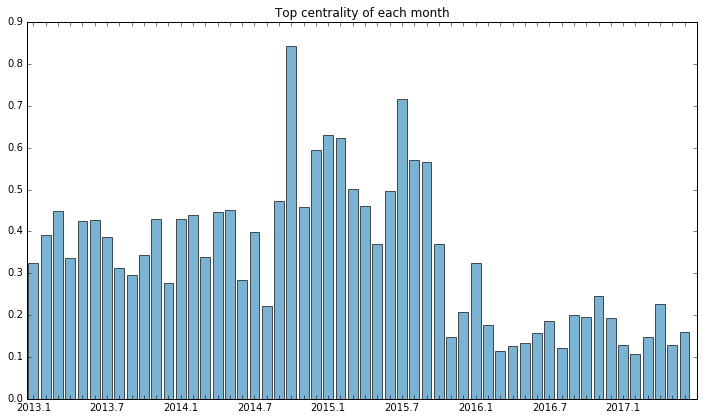

In [45]:

plt.figure(figsize=(12, 6.75), facecolor="white")
plt.bar(range(len(s)), s, color="#348ABD", alpha=0.65,
            label="Top centrality of each month", align="center")
#plt.ylim([75,110])
plt.xticks(range(len(s)), s.index.map(lambda t: str(t[0]) + "." + str(t[1]) if t[1] % 6 == 1 else ""))
plt.xlim([-0.5, len(s)])
plt.title("Top centrality of each month")
plt.show()

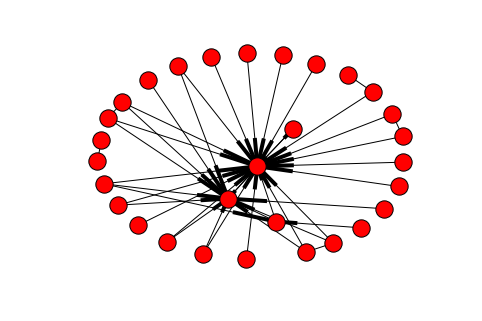

In [101]:
plt.figure(facecolor="white")
nx.draw_spring(g_before)

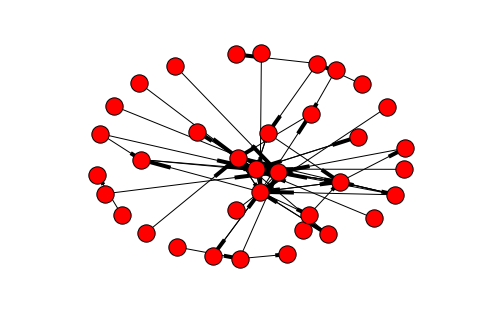

In [100]:
plt.figure(facecolor="white")
nx.draw_spring(g_after)

In [63]:
print plt.rcParams["axes.edgecolor"], plt.rcParams["axes.linewidth"]

k 1.0


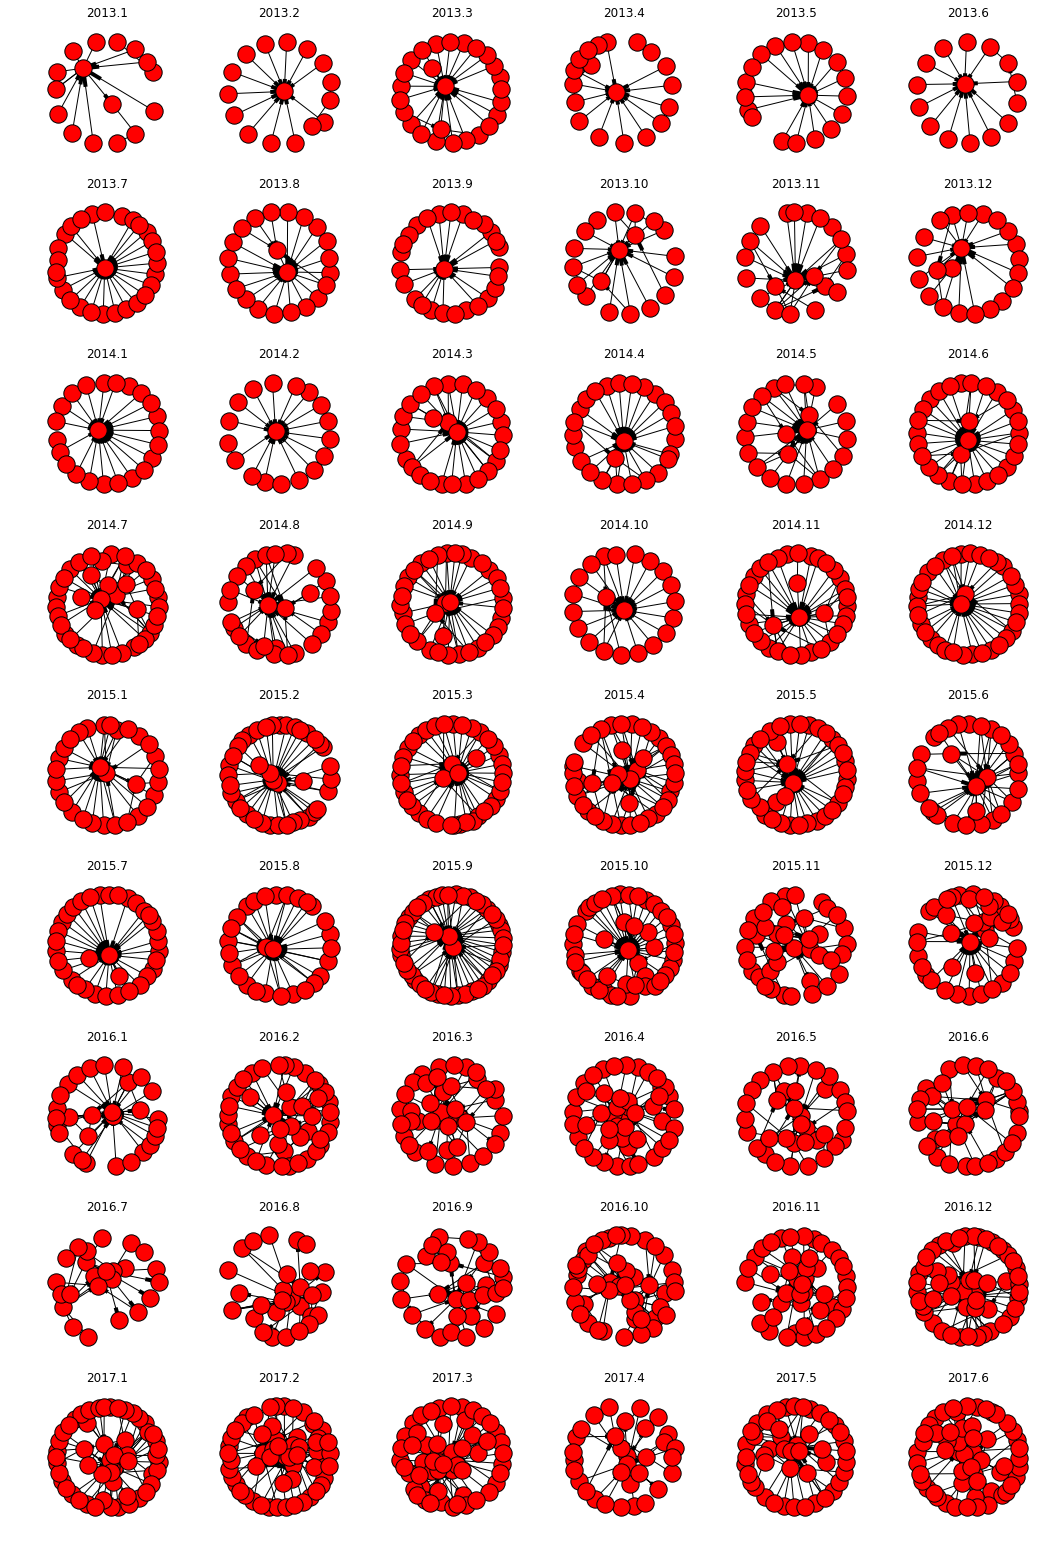

In [69]:

plt.figure(figsize=(18, 27), facecolor="white")

count = 0
for year in range(2013, 2018):
    for month in range(1, 13):
        if year == 2017 and month == 7:
            break
        count += 1
        g = to_graph(log[(year, month)])
        ax = plt.subplot(9,6,count)
        plt.title(str(year) + '.' + str(month))
        nx.draw_spring(g)


In [70]:
# bayesian inference on centrality

In [71]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt

In [74]:
data = s
n_data = len(data)

In [77]:
with pm.Model() as model:
    mu1 = pm.Uniform("mu1", lower=0, upper=1)
    var1 = pm.Uniform("var1", lower=0, upper=mu1 * (1-mu1))
    mu2 = pm.Uniform("mu2", lower=0, upper=1)
    var2 = pm.Uniform("va2", lower=0, upper=mu2 * (1-mu2))
      
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_data - 1)
    idx = np.arange(n_data) # Index
    
    mu = pm.math.switch(tau >= idx, mu1, mu2)
    var = pm.math.switch(tau >= idx, var1, var2)
    
    sd = pm.math.sqrt(var)
    observation = pm.Beta("obs", mu=mu, sd=sd, observed=data)
    
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step, njobs=1)
    
    


100%|██████████████████████████████████████████████████████████████████████████| 15000/15000 [00:08<00:00, 1831.95it/s]


In [80]:
mu_1_samples = trace['mu1']
mu_2_samples = trace['mu2']
tau_samples = trace['tau']

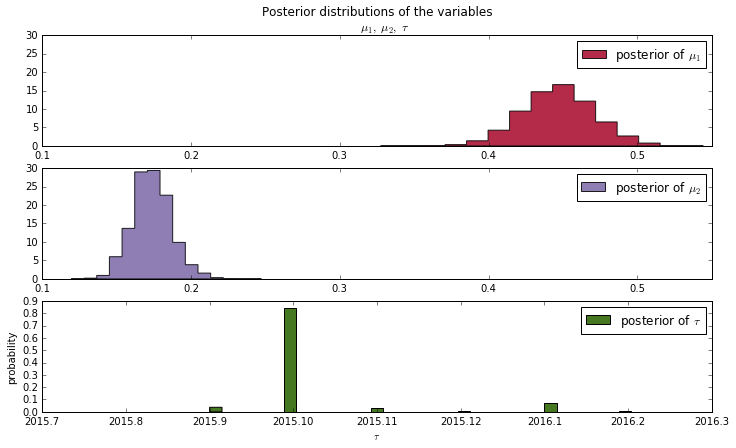

In [93]:
plt.figure(figsize=(12, 6.75), facecolor="white")
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(mu_1_samples, histtype='stepfilled', bins=15, alpha=0.85,
         label="posterior of $\mu_1$", color="#A60628", normed=True)
plt.legend(loc="upper right")
plt.title(r"""Posterior distributions of the variables
    $\mu_1,\;\mu_2,\;\tau$""")
plt.xlim([0.10, 0.55])
plt.ylim([0.0,30.0])
plt.xlabel("$\mu_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(mu_2_samples, histtype='stepfilled', bins=15, alpha=0.85,
         label="posterior of $\mu_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper right")
plt.xlim([0.10, 0.55])
plt.ylim([0.0,30.0])
plt.xlabel("$\mu_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(range(n_data), data.index.map(lambda t: str(t[0]) + '.'+ str(t[1])))
plt.xlim([30, 38])


plt.legend(loc="upper right")
#plt.ylim([0, .4])
plt.xlabel(r"$\tau$ ")
plt.ylabel("probability");

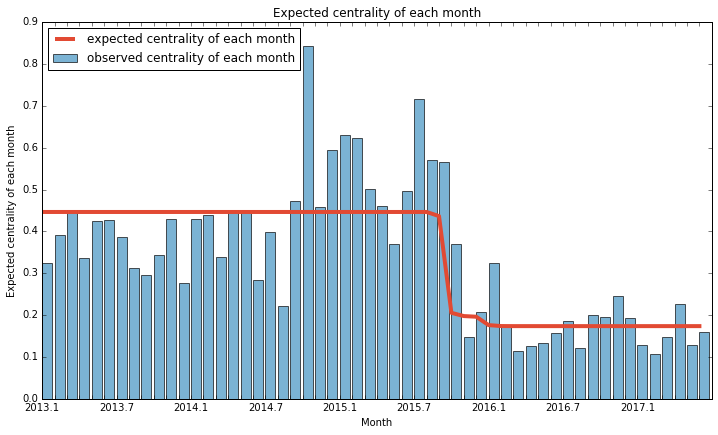

In [99]:

plt.figure(figsize=(12, 6.75), facecolor="white")

N = tau_samples.shape[0]
expected_centrality = np.zeros(n_data)
for day in range(0, n_data):

    ix = day < tau_samples

    expected_centrality[day] = (mu_1_samples[ix].sum()
                                   + mu_2_samples[~ix].sum()) / N


plt.plot(range(n_data), expected_centrality, lw=4, color="#E24A33",
         label="expected centrality of each month")
plt.xticks(range(n_data), data.index.map(lambda t: str(t[0]) + '.' + str(t[1]) if (t[1]%6 == 1) else ""))
plt.xlim(0, n_data)
plt.xlabel("Month")
plt.ylabel("Expected centrality of each month")
plt.title("Expected centrality of each month")
#plt.ylim(0, 60)
plt.bar(np.arange(len(data)), data, color="#348ABD", alpha=0.65,
        label="observed centrality of each month")

plt.legend(loc="upper left");